In [54]:
import os 
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import datetime
import re
import math

In [55]:
# load data using pandas from csv files in Data_with mouse Id 
# Data_wite mouse Id is a folder in the same directory as this file
path = 'Data_with mouse ID/data'
files = os.listdir(path)
files = [path + '/' + file for file in files]
 
 # load a dict of files keyed with the file name
log_data = {file.split('/')[-1].split('.')[0]: pd.read_csv(file) for file in files}
# get array of file names 
file_names = list(log_data.keys())
file_names.sort()

mouse_name_list = ['M' + str(i) for i in range(1,9)]
mouse_break_times = dict(zip(mouse_name_list, np.empty((8, 2))))
successful_trials_by_day = dict()

In [56]:
def subtract_time_series(x, index1, index2):
    time_str1 = str(x[index1])
    time_str2 = str(x[index2])
    if time_str2 == 'nan':
        return None
    secs1 = float(str(x[index1])[12:14])
    secs2 = float(str(x[index2])[12:14])
    millis1 = float(str(x[index1])[14:])
    millis2 = float(str(x[index2])[14:])
    mins1 = float(str(x[index1])[10:12])
    mins2 = float(str(x[index2])[10:12])
    # divide millis until there is nothing to the right of the decimal point
    while millis1 > 1:
        millis1 /= 10
    while millis2 > 1:
        millis2 /= 10
    secs1 += millis1
    secs2 += millis2

    if secs2 < secs1:
        x =  abs(mins2 - mins1) * 60 + (secs2 - secs1) 
    else:
        x =  (secs2 - secs1) 
    return x


In [86]:
def process_time_string(time_string):
    time_string = str(time_string)
    if time_string == 'nan':
        return None
    if len(time_string) > 14:
        millis = float(time_string[14:])
    else:
        millis = 0
    secs = int(time_string[12:14])
    mins = int(time_string[10:12])
    hours = int(time_string[8:10])
    day = int(time_string[6:8])
    month = int(time_string[4:6])
    year = int(time_string[0:4])
    # divide millis until there is nothing to the right of the decimal point
    while millis > 1:
        millis /= 10
    return datetime.datetime(year, month, day, hours, mins, secs, int(millis * 1000))

In [87]:
M1_M2 = []
M3_M4 = []
M5_M6 = []
M7_M8 = []
for file in file_names:
    df = log_data[file]
    matches = [ re.match('(M)[1-8]_[L | R]_beambreak_time in s', name) for name in df.columns.to_list()]
    for match in matches:
        if match is not None:
            if match.string.split('_')[1] == 'R':
                R = match.string
            else:
                L = match.string
    # get the time at the start of the trial
    start_time = process_time_string(file.split('_')[0])
    # get the datetime of each cue
    cue_times = df['cue_time in s'].apply(lambda x : process_time_string(x))
    # subtract the start time from each cue time
    time_since_start = cue_times.apply(lambda x : x - start_time)
    # Get the names of each mouse
    mouse_name_L = L.split('_')[0]
    mouse_name_R = R.split('_')[0]
    # subtract the 2nd collumn from the 4th abd 7th collumns
    mouse_L_break_time = df.apply(lambda x : subtract_time_series(x, 'cue_time in s', L), axis=1)
    mouse_R_break_time = df.apply(lambda x : subtract_time_series(x, 'cue_time in s', R), axis=1)
    # run through both to see when both broke the beam, then record as a success for the day
    sucessful_trials = []
    # absolute difference between mouse L and mouse R break times
    time_between_breaks = []
    for i in range(len(mouse_L_break_time)):
        if not math.isnan(mouse_L_break_time[i]) and not math.isnan(mouse_R_break_time[i]) :
            sucessful_trials.append(True)
            time_between_breaks.append(abs(mouse_L_break_time[i] - mouse_R_break_time[i]))
        else:
            sucessful_trials.append(False)
            time_between_breaks.append(None)
    successful_trials_by_day[file] = {
        'names' : mouse_name_L + mouse_name_R,
        'L': mouse_L_break_time,
        'R': mouse_R_break_time,
        'successful_trials': sucessful_trials,
        'time_between_breaks': time_between_breaks,
        'time_since_start': time_since_start,
        'cue_times': cue_times}
    if mouse_name_L == 'M1' or mouse_name_L == 'M2':
        M1_M2.append(file)
    elif mouse_name_L == 'M3' or mouse_name_L == 'M4':
        M3_M4.append(file)
    elif mouse_name_L == 'M5' or mouse_name_L == 'M6':
        M5_M6.append(file)
    elif mouse_name_L == 'M7' or mouse_name_L == 'M8':
        M7_M8.append(file)
    # convert successful trials by day to a dataframe
    successful_trials_df = pd.DataFrame(successful_trials_by_day[file])
    # save the dataframe to a csv file
    successful_trials_df.to_csv('successful_trials_by_day/' + file + '.csv')
    mouse_break_times[mouse_name_L] = np.concatenate((mouse_break_times[mouse_name_L], ( mouse_L_break_time.array)))
    mouse_break_times[mouse_name_R] = np.concatenate((mouse_break_times[mouse_name_R], ( mouse_R_break_time.array)))
# add all the mouse pairs to a dict
mouse_pairs = {
    'M1_M2': M1_M2,
    'M3_M4': M3_M4,
    'M5_M6': M5_M6,
    'M7_M8': M7_M8
}

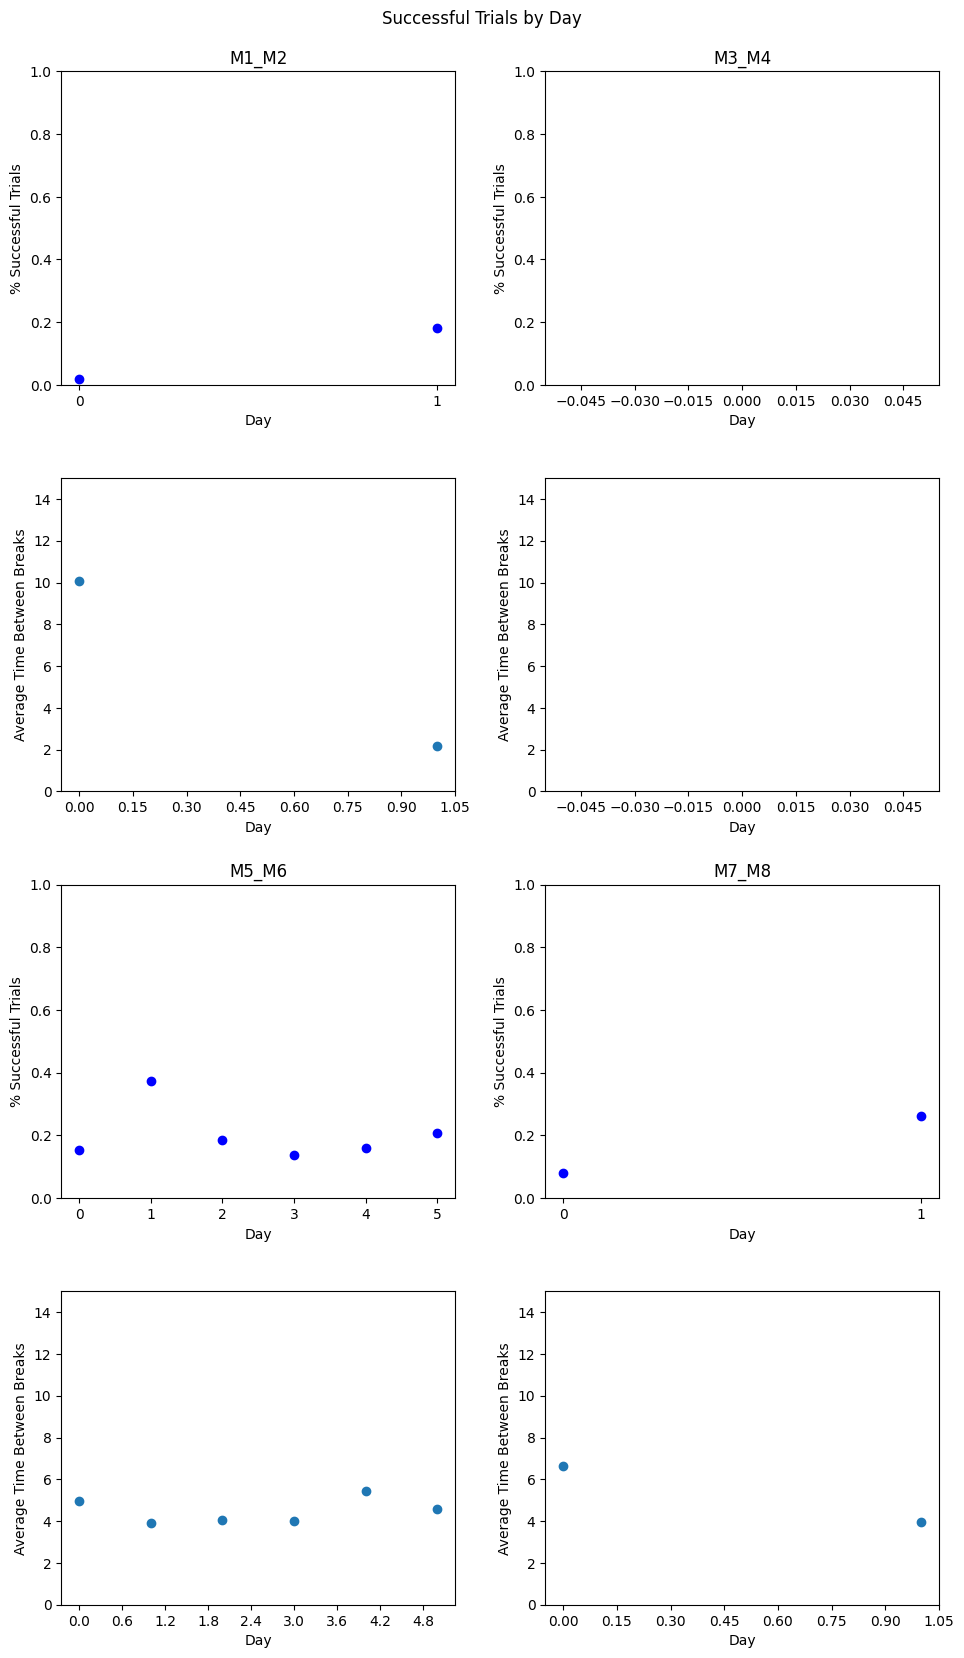

In [88]:
# iterate through all mouse pairs and plot # successes
# create 8 subplots
fig, axs = plt.subplots(4, 2)
fig.suptitle('Successful Trials by Day')
# enlarge figure
fig.set_size_inches(10, 17)
# iterate through mouse pairs
for i, pair in enumerate(mouse_pairs):
    trials_success_rate = []
    average_time_between_breaks = []
    L_mean_break_times = []
    R_mean_break_times = []
    for file in mouse_pairs[pair]:
        # only take files with more than 10 entries
        if len(successful_trials_by_day[file]['successful_trials']) > 50 and (sum(successful_trials_by_day[file]['successful_trials'])) > 0:
            trials_success_rate.append(sum(successful_trials_by_day[file]['successful_trials']) / len(successful_trials_by_day[file]['successful_trials']))
            time_between_breaks = [x for x in successful_trials_by_day[file]['time_between_breaks'] if x is not None]
            R_mean_break_times.append(np.mean(successful_trials_by_day[file]['R']))
            L_mean_break_times.append(np.mean(successful_trials_by_day[file]['L']))
            if len(time_between_breaks) > 0:
                average_time_between_breaks.append(np.mean(time_between_breaks))
            else:
                average_time_between_breaks.append(None)
    # plot the Success rate for each day
    axs[(i//2) * 2, i%2].scatter(range(len(trials_success_rate)), trials_success_rate, color='blue')
    axs[(i//2) * 2, i%2].set_title(pair)
    axs[(i//2) * 2, i%2].set_xlabel('Day')
    axs[(i//2) * 2, i%2].set_ylabel('% Successful Trials')
    # set y range to include 0 and 1
    axs[(i//2) * 2, i%2].set_ylim([0, 1])
    # make x ticks integers
    axs[(i//2) * 2, i%2].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    # plot the average time between breaks for each day
    axs[(i//2) * 2 + 1, i%2].scatter(range(len(trials_success_rate)), average_time_between_breaks)
    axs[(i//2) * 2 + 1, i%2].set_xlabel('Day')
    axs[(i//2) * 2 + 1, i%2].set_ylabel('Average Time Between Breaks')    # make x ticks integers
    axs[(i//2) * 2 + 1, i%2].xaxis.set_major_locator(plt.MaxNLocator(10))
    # set y lim between 0 and 15
    axs[(i//2) * 2 + 1, i%2].set_ylim([0, 15])
   
# space the plots so titles dont overlap
fig.tight_layout(pad=2.0)
plt.show()

In [59]:
# for each mose in mouse_break_times, plot a scatter plot of the break times
clean_mouse_break_times = dict()
for mouse in mouse_break_times:
    # remove all nan values
    clean_mouse_data = mouse_break_times[mouse][~np.isnan(mouse_break_times[mouse])]
    # remove first two values
    clean_mouse_data = clean_mouse_data[2:]
    # remove outlier values greater than 60
    clean_mouse_data = clean_mouse_data[clean_mouse_data < 60]
    clean_mouse_break_times[mouse] = clean_mouse_data


/tmp/ipykernel_191309/1695015274.py:4: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  clean_mouse_break_times = {key: value for key, value in clean_mouse_break_times.items() if value != []}
/tmp/ipykernel_191309/1695015274.py:4: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  clean_mouse_break_times = {key: value for key, value in clean_mouse_break_times.items() if value != []}


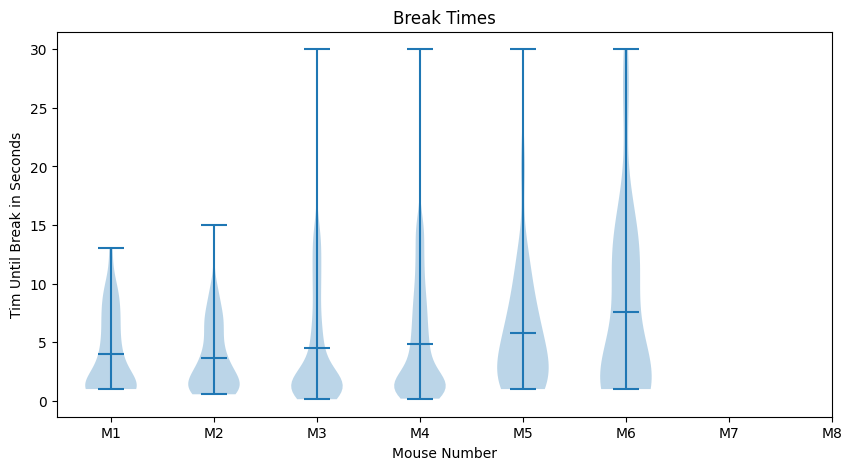

In [60]:
# violin plot of break times per mouse
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
# filter none values from dict
clean_mouse_break_times = {key: value for key, value in clean_mouse_break_times.items() if value != []}
mouse_break_array = (list(clean_mouse_break_times.values()))
axs.violinplot(mouse_break_array[0:8], showmeans=True)
axs.set_title('Break Times')
axs.set_xlabel('Mouse Number')
axs.set_ylabel('Tim Until Break in Seconds')
axs.set_xticks(range(1,9))
axs.set_xticklabels(mouse_name_list)
plt.show()
